# Package and distribution identification in 24 hour clusters

Goal: 
    
    Determine package contribution to the 24 hour load profile clusters and which clusters each package belongs to most.

Purpose:

    Identify differences in load profiles.

## Steps:

A. Processing data for 24 hour analyses:  
B. Clustering   
C. Given clusters of 24 hour load profiles (Model 2, 10 minute data) determine:
    
    1. For each of the 225 district clusters, which packages contribute to the cluster (ie. cluster 1 is composed of 10% psn 56, 4% of 63, 3% of 62, etc.)
    2. For each package, determine which clusters the package belongs to most (ie. psn 56 belongs 50% to cluster 1, 30% cluster 3, 2% to cluster 223, etc. This might suggest that this package has mostly steady single load behavior, with a couple conditions of step size shifts.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn import metrics

from sqlalchemy import create_engine
import datetime 
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib
from TurbineTimeSeries.storage import MachineDataStore
#from TurbineTimeSeries.transformations import PCA, StandardScaler, DropCols, DropSparseCols, LeftJoin

In [2]:
model_number = 2

store = MachineDataStore('.config')

model_data_hr = (store.query(model_number,'1hr')
                 .not_null(['timestamp','psn'])
                 .exclude_psn([44,52,54,70])
                 .execute())

model_data_min = (store.query(model_number,'10min')
                  .not_null(['timestamp','psn'])
                  .exclude_psn([44,52,54,70])
                  .execute())

model_data_min.head()

,id,lo_c_dp1,f_c_dp1,f_c_dp2,f_c_dp5,pe_c_dt1,g_c_dt1,g_c_dt2,lo_c_dt5,c_dt5_1,...,v_d_2b,lo_t5,g_t2,f_t1,sum_enr,g_t3,g_pct1,f_pos1,timestamp,psn
0,695650,0.227756,-0.076920,-0.096149,0.168523,0.543333,0.402,0.440,0.554118,0.051556,...,0.183143,0.741739,0.831429,0.5030,5199.398481,0.6004,0.16508,0.335737,2017-01-02 13:49:59.999998,56
1,695651,0.219428,-0.076920,-0.144226,0.168526,0.542222,0.396,0.436,0.555294,0.047722,...,0.183143,0.741739,0.829714,0.5005,5199.511899,0.6068,0.16124,0.335336,2017-01-02 14:00:00.000003,56
2,695652,0.227756,-0.115381,-0.144249,0.167950,0.538889,0.402,0.446,0.552941,0.048000,...,0.183143,0.741304,0.833143,0.5030,5199.625316,0.6012,0.17775,0.335737,2017-01-02 14:09:59.999997,56
3,695653,0.223726,-0.076920,-0.096149,0.168138,0.535556,0.400,0.450,0.556471,0.042389,...,0.184057,0.742609,0.834286,0.5030,5199.738734,0.6000,0.16568,0.334535,2017-01-02 14:20:00.000002,56
4,695654,0.229772,-0.115381,-0.096149,0.168523,0.543333,0.396,0.442,0.556471,0.044500,...,0.184057,0.742609,0.832000,0.5025,5199.852658,0.5988,0.16390,0.335336,2017-01-02 14:29:59.999996,56


In [3]:
freq = '10min'
model_data = model_data_min
len(model_data)

1602326

## A. Processing data for 30 min segment analyses:

    ● Drop sparse packages without any complete days 
    ● Drop engine starts and engine hour tags
    ● Drop records with any nulls 
    ● Standardize features to 0 mean and unit variance 
    ● PCA on sensor data, each row a point in time with 70 features The top eigenvectors for Model 2, differing from Model 1, correspond to temperature (Eigenvector 1) and actuator states, which correspond to the positions of the various valves throughout the package (Eigenvector 2). Eigenvectors 3 and 4 are less clear cut, but are related to pressure. 

In [4]:
skipped_cols = ['sum_esn','sum_eng_st', 'sum_eng_h']
index_cols = ['id','timestamp','psn']
data_cols = [c for c in model_data.columns if (c not in index_cols) and (c not in skipped_cols)]

In [5]:
missing_values = model_data.isnull().sum().sort_values()
sparse_cols = [x for x in missing_values.index if missing_values[x] > 30000]
clean_data_cols = [x for x in data_cols if x not in sparse_cols]

In [6]:
data = model_data[index_cols + clean_data_cols].dropna().reset_index()
clean_data = StandardScaler().fit_transform(data[clean_data_cols])

pca =  PCA().fit(clean_data)
reduced = pca.transform(clean_data)

In [7]:
def roundTime(dt=None, roundTo=60):
    """Round a datetime object to any time laps in seconds
    dt : datetime.datetime object, default now.
    roundTo : Closest number of seconds to round to, default 1 minute.
    Author: Thierry Husson 2012 - Use it as you want but don't blame me.
    """
    if dt == None : dt = datetime.datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)
n = datetime.datetime(2015,12,5,0,10,0,4)
print(n)
print(roundTime(n,600))

2015-12-05 00:10:00.000004
2015-12-05 00:10:00


In [8]:
eigenvectors_to_segment = 4
half_hour_segments = []
mapping = []

def half_hour_group(x):
    return str(x['iso'][0])+'-'+str(x['iso'][1])+'-'+str(x['iso'][2])+'-'+str(x['hour'])+'-'+('0' if x['minute'] < 30 else '1')

for i in range(eigenvectors_to_segment):
    half_hour_segments.append([])
    
for psn in data['psn'].sort_values().unique():
    print(str(psn), datetime.datetime.now())
    psn_data = pd.DataFrame(data[(data['psn'] == psn)])
    psn_data['timestamp'] = psn_data['timestamp'].apply(lambda x: roundTime(datetime.datetime(x.year,x.month,x.day,x.hour,x.minute,x.second),600))
    psn_data['iso'] = psn_data['timestamp'].apply(lambda x: x.isocalendar())
    psn_data['hour'] = psn_data['timestamp'].apply(lambda x: x.time().hour)
    psn_data['minute'] = psn_data['timestamp'].apply(lambda x: x.time().minute)
    print('\t time parsing done', datetime.datetime.now())
    psn_data['half_hour_group'] = psn_data.apply(half_hour_group,1)
    complete_groups = (psn_data.groupby(by=['half_hour_group']).count()['id'] == 3)
    psn_data['complete_group'] = psn_data['half_hour_group'].apply(lambda x: complete_groups[x])
    psn_data = psn_data[psn_data['complete_group'] == True]
    print('\t block grouping done', datetime.datetime.now())
   
    for d in psn_data['half_hour_group'].unique():
        group_data = (psn_data[psn_data['half_hour_group'] == d]).sort_values(by='minute')
        idx = group_data.index
        ids = list(group_data['id'])
        mapping.append({'psn': psn, 'half_hour_group': d, 'ids': ids})
        
        for i in range(eigenvectors_to_segment):
            half_hour_segments[i].append([x for x in reduced[idx,i]])
    
    print('\t block aggregating done', datetime.datetime.now())

34 2018-05-09 00:59:14.104657
	 time parsing done 2018-05-09 00:59:15.835655
	 block grouping done 2018-05-09 00:59:29.113112
	 block aggregating done 2018-05-09 01:04:07.450060
35 2018-05-09 01:04:07.450060
	 time parsing done 2018-05-09 01:04:08.542056
	 block grouping done 2018-05-09 01:04:15.394061
	 block aggregating done 2018-05-09 01:06:31.021104
36 2018-05-09 01:06:31.021104
	 time parsing done 2018-05-09 01:06:32.095103
	 block grouping done 2018-05-09 01:06:38.911103
	 block aggregating done 2018-05-09 01:08:49.982149
37 2018-05-09 01:08:49.982149
	 time parsing done 2018-05-09 01:08:51.020147
	 block grouping done 2018-05-09 01:08:57.376149
	 block aggregating done 2018-05-09 01:11:08.392189
38 2018-05-09 01:11:08.392189
	 time parsing done 2018-05-09 01:11:08.792190
	 block grouping done 2018-05-09 01:11:11.791190
	 block aggregating done 2018-05-09 01:11:49.059203
39 2018-05-09 01:11:49.059203
	 time parsing done 2018-05-09 01:11:49.362202
	 block grouping done 2018-05-09 

In [9]:
print('An example of what the mapping dictionary will look like: \n', len(mapping), mapping[0])

An example of what the mapping dictionary will look like: 
 533008 {'psn': 34, 'half_hour_group': '2015-49-6-0-0', 'ids': [1211745, 1211746, 1211747]}


## B. Clustering

    To understand these daily behaviors better, we ran the K-Means clustering algorithm on all 24 hour segments from all packages. 
    
Types of patterns seen:
    
    ● A relatively stable daily fluctuation. This pattern represents normal operating and dominates most of the clusters. Each cluster represents a different load on the package. We have found each package typically has a high and low operating modes.
    ● Normal operating interrupted by one or more jumps between operating modes.
    ● Normal operating interrupted by a quick, sharp spike. This pattern represents transient states as defined in Modeling->Analytic Approach.

In [10]:
def plot_cluster_distribution(n_clusters):
    plt.rcParams["figure.figsize"] = (15,15)
    fig = plt.figure(0)
    ax1 = plt.subplot2grid((1,1), (0, 0))
    ax1.bar(range(n_clusters),label_counts[:])
    ax1.set_ylabel('Segment Count')
    ax1.set_xlabel('Cluster')
    plt.suptitle("Model {} Cluster Distributions for Eigenvector {}, 30 Minute Profiles".format(model_number, j+1))
    plt.grid("on")
    fig.savefig("model{}_kmeans_{}_eig{}_30_min_cluster_distribution.png".format(model_number, n_clusters,j+1))
       
    plt.show()
    
def plot_cluster_grid():
    plt.rcParams["figure.figsize"] = (15,15)
    plt.show()

    grid_size = (n_clusters,1)
    cluster_means = []

    fig = plt.figure(0)
    row = -1
    shared_ax = None

    for i,c in enumerate(labels_sorted_by_freq):
        cluster_data = [to_be_clustered[j] for j in range(len(cluster.labels_)) if cluster.labels_[j] == c]
        cluster_means.append(pd.DataFrame(cluster_data).mean())
        
        col = i%15
        row = row if col > 0 else row+1
        
        ax = plt.subplot2grid((15,15), (row,col),sharey=shared_ax)
        
        ax.plot(pd.DataFrame(cluster_data).T,alpha=0.2, color='red')
        plt.axis('off')
        
        if shared_ax is None:
            shared_ax = ax     

        
    plt.suptitle("Model {} Eigenvector {}, 30 Minute Profiles".format(model_number, j+1))  
    fig.savefig("model{}_kmeans_{}_eig{}_30_min_cluster_grid.png".format(model_number, n_clusters,j+1))
    plt.close()
    
def plot_clusters(c_idx):
    plt.rcParams["figure.figsize"] = (14, 7)
    for i, c in enumerate(c_idx):
        cluster_data = [to_be_clustered[j] for j in range(len(cluster.labels_)) if cluster.labels_[j] == c]
                
        fig = plt.figure(0)
        ax = plt.subplot2grid((1,1), (0,0))
        ax.plot(pd.DataFrame(cluster_data).T,alpha=0.2, color='red')
        ax.set_xlabel('Time of Day')
        plt.suptitle("Model {} Eigenvector {}, 30 Minute Cluster {} ".format(model_number, j+1, i+1))  
        fig.savefig("model{}_kmeans_{}_eig{}_30_min_cluster{}.png".format(model_number, n_clusters,j+1, i+1))
        plt.close()
      

C:\Users\ostus\Desktop\Capstone\AnomalyDetectionMachineData\eda\package_identification_30minclusters_60clusters


C:\Users\ostus\Anaconda3\envs\Capstone\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


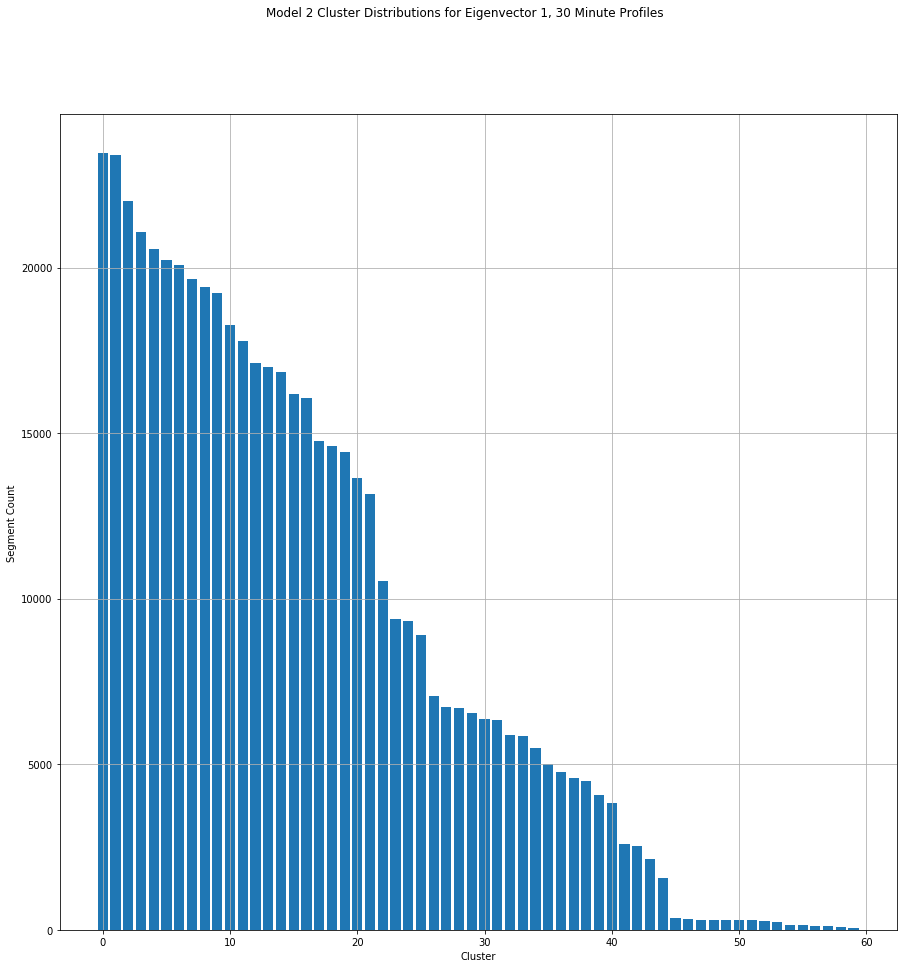

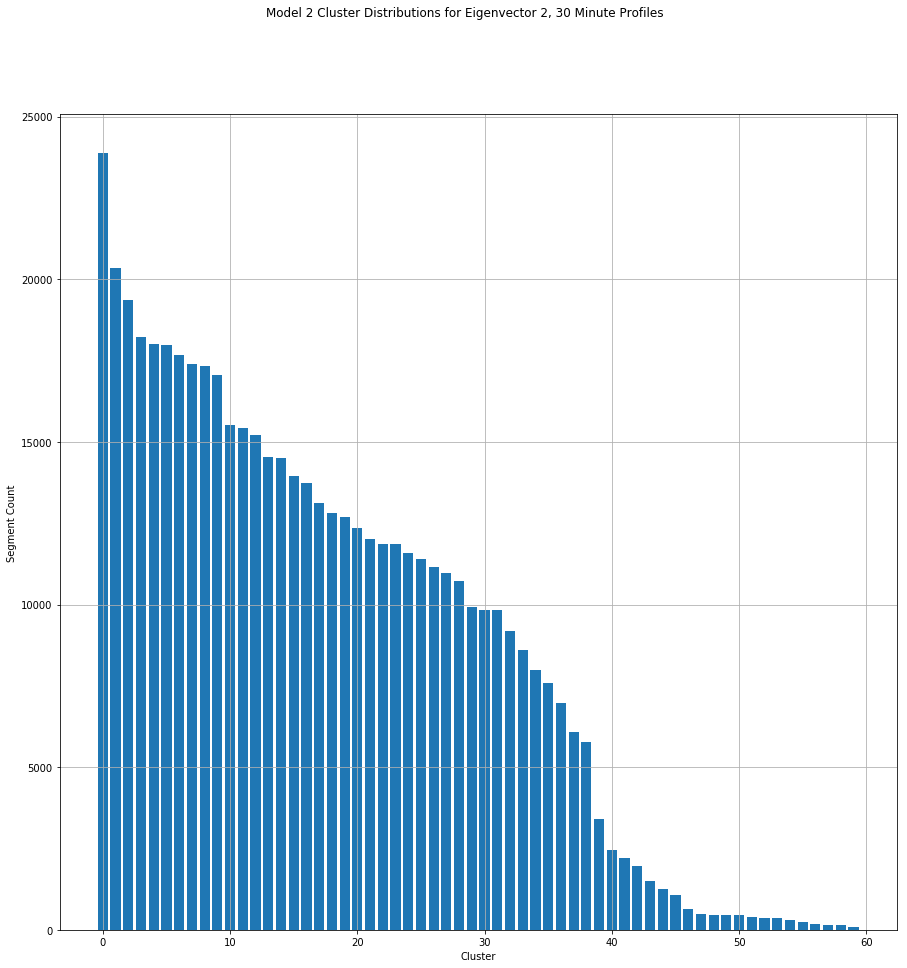

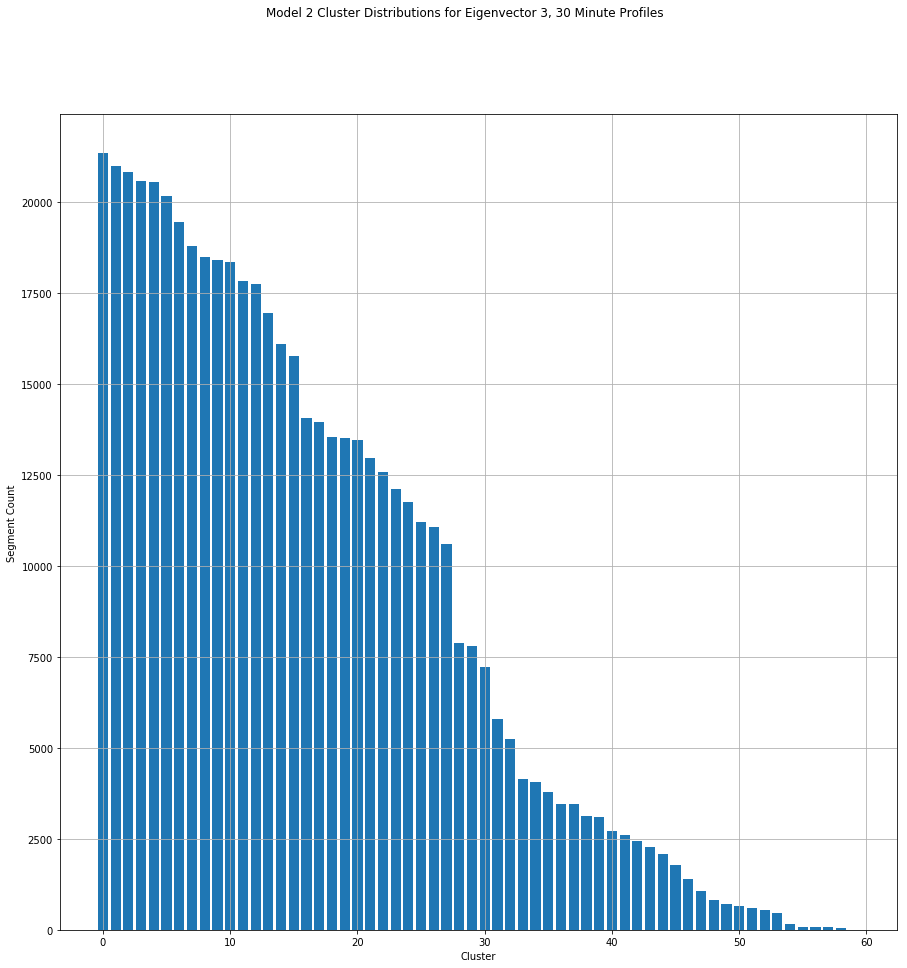

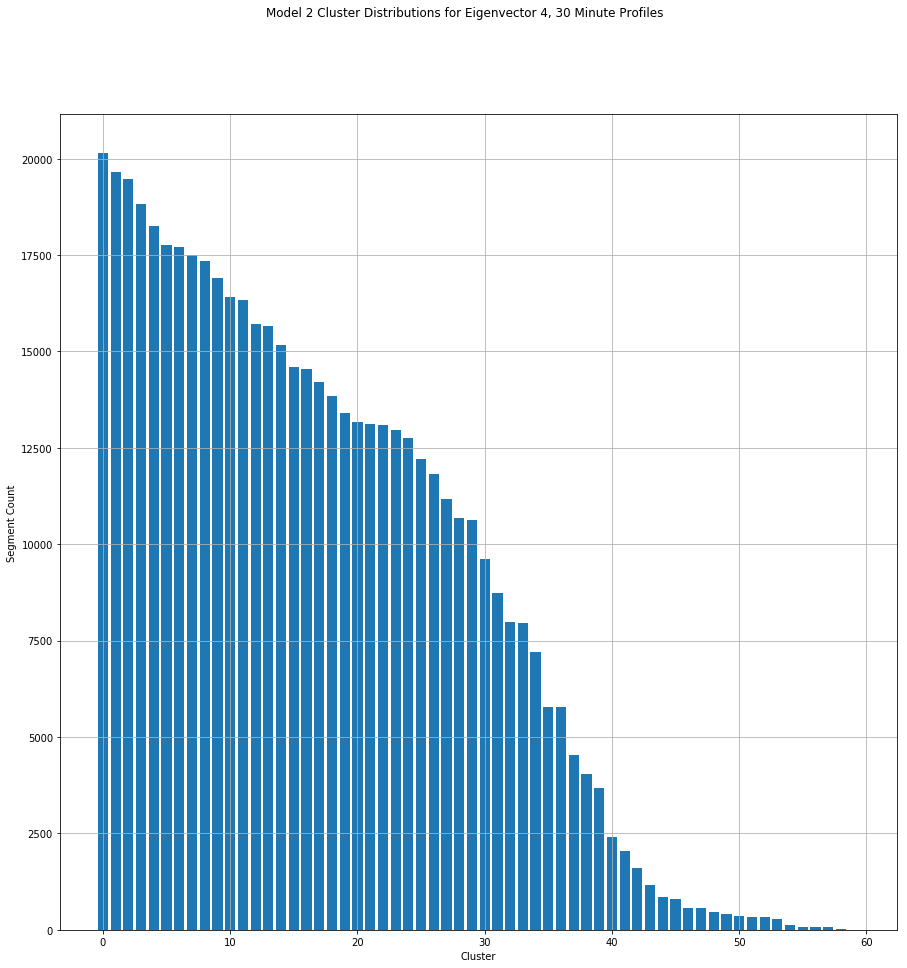

C:\Users\ostus\Desktop\Capstone\AnomalyDetectionMachineData\eda


In [11]:
n_cluster = 60
folderOutput = './package_identification_30minclusters_{}clusters/'.format(n_cluster)
%cd $folderOutput


sortedLabels = {}
for j, daily_coefficients in enumerate(half_hour_segments):
    i = 0
    to_be_clustered = daily_coefficients
    n_clusters=60

    cluster = KMeans(n_clusters)
    cluster.fit(to_be_clustered)
    for label in cluster.labels_:
        mapping[i]['label_eig'+str(j+1)] = label
        i += 1    
    label_df = pd.DataFrame(cluster.labels_)
    label_counts = label_df[0].value_counts().sort_values(ascending=False)
    labels_sorted_by_freq = list(label_counts.keys())
    
    plot_cluster_distribution(n_clusters=n_clusters)
    plot_cluster_grid()
    if j == 0:
        plot_clusters(labels_sorted_by_freq)
        
    sortedLabels['label_eig'+str(j+1)] = dict(zip(labels_sorted_by_freq, range(225)))

%cd ..

## C. Given clusters of 30 min load profiles (Model 2, 10 minute data) determine:
    
    1. For each of the distinct clusters, which packages contribute to the cluster (ie. cluster 1 is composed of 10% psn 56, 4% of 63, 3% of 62, etc.)
    2. For each package, determine which clusters the package belongs to most (ie. psn 56 belongs 50% to cluster 1, 30% cluster 3, 2% to cluster 223, etc. This might suggest that this package has mostly steady single load behavior, with a couple conditions of step size shifts.
    
    
But first, we need to fill in the associated cluster results & cluster result frequency order into the original dataset.

In [12]:
ind = []
eig1 = []
eig2 = []
eig3 = []
eig4 = []
for i  in range(len(mapping)):
    indexes = mapping[i]['ids']
    ind.extend(mapping[i]['ids'])
    eig1.extend([mapping[i]['label_eig1']]*len(indexes))
    eig2.extend([mapping[i]['label_eig2']]*len(indexes))
    eig3.extend([mapping[i]['label_eig3']]*len(indexes))
    eig4.extend([mapping[i]['label_eig4']]*len(indexes))
clusterLabels = pd.DataFrame({'id': ind, 'eig1': eig1, 'eig2': eig2, 'eig3': eig3, 'eig4': eig4})
clusterLabels['eig1_order'] = clusterLabels['eig1'].map(sortedLabels['label_eig1'])
clusterLabels['eig2_order'] = clusterLabels['eig2'].map(sortedLabels['label_eig2'])
clusterLabels['eig3_order'] = clusterLabels['eig3'].map(sortedLabels['label_eig3'])
clusterLabels['eig4_order'] = clusterLabels['eig4'].map(sortedLabels['label_eig4'])
clusterLabels.head()

,eig1,eig2,eig3,eig4,id,eig1_order,eig2_order,eig3_order,eig4_order
0,46,27,15,46,1211745,21,2,4,12
1,46,27,15,46,1211746,21,2,4,12
2,46,27,15,46,1211747,21,2,4,12
3,46,1,15,46,1211748,21,5,4,12
4,46,1,15,46,1211749,21,5,4,12


In [13]:
# Merge to dataframe data
print('Shape of data: ', data.shape, '\nShape of clusterLabels: ', clusterLabels.shape)
data.head()

Shape of data:  (1602282, 74) 
Shape of clusterLabels:  (1599024, 9)


,index,id,timestamp,psn,lo_c_dp1,f_c_dp1,f_c_dp2,f_c_dp5,pe_c_dt1,g_c_dt1,...,f_p7,f_p1,v_d_2b,lo_t5,g_t2,f_t1,sum_enr,g_t3,g_pct1,f_pos1
0,0,695650,2017-01-02 13:49:59.999998,56,0.227756,-0.076920,-0.096149,0.168523,0.543333,0.402,...,15.348557,0.647267,0.183143,0.741739,0.831429,0.5030,5199.398481,0.6004,0.16508,0.335737
1,1,695651,2017-01-02 14:00:00.000003,56,0.219428,-0.076920,-0.144226,0.168526,0.542222,0.396,...,15.360575,0.648279,0.183143,0.741739,0.829714,0.5005,5199.511899,0.6068,0.16124,0.335336
2,2,695652,2017-01-02 14:09:59.999997,56,0.227756,-0.115381,-0.144249,0.167950,0.538889,0.402,...,15.348557,0.647773,0.183143,0.741304,0.833143,0.5030,5199.625316,0.6012,0.17775,0.335737
3,3,695653,2017-01-02 14:20:00.000002,56,0.223726,-0.076920,-0.096149,0.168138,0.535556,0.400,...,15.336537,0.646761,0.184057,0.742609,0.834286,0.5030,5199.738734,0.6000,0.16568,0.334535
4,4,695654,2017-01-02 14:29:59.999996,56,0.229772,-0.115381,-0.096149,0.168523,0.543333,0.396,...,15.348557,0.647267,0.184057,0.742609,0.832000,0.5025,5199.852658,0.5988,0.16390,0.335336


In [14]:
labeledData = pd.merge(data[['id', 'timestamp', 'psn']], clusterLabels, on='id')
labeledData['iso'] = labeledData['timestamp'].apply(lambda x: x.isocalendar())
labeledData['hour'] = labeledData['timestamp'].apply(lambda x: x.time().hour)
labeledData['minute'] = labeledData['timestamp'].apply(lambda x: x.time().minute)
labeledData['half_hour_group'] = labeledData.apply(half_hour_group,1)
labeledData.head()

,id,timestamp,psn,eig1,eig2,eig3,eig4,eig1_order,eig2_order,eig3_order,eig4_order,iso,hour,minute,half_hour_group
0,695650,2017-01-02 13:49:59.999998,56,0,4,51,3,1,0,27,34,"(2017, 1, 1)",13,49,2017-1-1-13-1
1,695651,2017-01-02 14:00:00.000003,56,0,4,35,3,1,0,30,34,"(2017, 1, 1)",14,0,2017-1-1-14-0
2,695652,2017-01-02 14:09:59.999997,56,0,4,35,3,1,0,30,34,"(2017, 1, 1)",14,9,2017-1-1-14-0
3,695653,2017-01-02 14:20:00.000002,56,0,4,35,3,1,0,30,34,"(2017, 1, 1)",14,20,2017-1-1-14-0
4,695654,2017-01-02 14:29:59.999996,56,0,4,4,22,1,0,12,35,"(2017, 1, 1)",14,29,2017-1-1-14-0


In [15]:
labeledData.to_csv(folderOutput+'dataLabeledWith30minClusters.csv', index=False)

### 1. For each of the distinct clusters, which packages contribute to the cluster (ie. cluster 1 is composed of 10% psn 56, 4% of 63, 3% of 62, etc.)

In [16]:
def packageDistributions(eigenvectorOfInterest):
    """ This functions considers the dataframe labeledData created above. Input the eigenvector of interest to transform the
    dataframe into a dataframe where the each row represents a particular cluster label (sorted in the descending order of 
    frequency), the columns represent specific PSNs, and each cell is populated by the number of PSN 24 segments which belong in
    that cluster. """
    eigDistribution = labeledData[['psn', 'iso','eig{}'.format(eigenvectorOfInterest), 'eig{}_order'.format(eigenvectorOfInterest)]].drop_duplicates()
    eigDistribution['count'] = 1
    eigDistribution = pd.DataFrame(eigDistribution.groupby(['psn', 'eig{}'.format(eigenvectorOfInterest)])['count'].sum()).unstack().fillna(0).T
    eigDistribution.reset_index(inplace = True)
    eigDistribution['sort'] = eigDistribution['eig{}'.format(eigenvectorOfInterest)].map(sortedLabels['label_eig{}'.format(eigenvectorOfInterest)])
    eigDistribution = eigDistribution.sort_values(by='sort')
    del eigDistribution['eig{}'.format(eigenvectorOfInterest)]
    del eigDistribution['level_0']
    del eigDistribution['sort']
    return eigDistribution

def plotHeatmap(eigDistribution, eigenvectorOfInterest):
    """ Takes a dataframe of a eigenvectorDistribution (ie. output from packageDistributions function) and outputs a heatmap
    where the darker the cell the more segments exist for the cluster, PSN combination. """
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(eigDistribution, cmap = 'Blues', linewidth=.5, cbar=False);
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.ylabel('Clusters (ordered by frequency)');
    plt.xlabel('PSN');
    plt.title('Package Distribution for Eigenvector {} Clusters in 30 min Load Profiles'.format(eigenvectorOfInterest), y=1.03);
    plt.yticks(rotation=0);
    
def plotClustermap(eigDistribution, eigenvectorOfInterest):
    """ Takes a dataframe of a eigenvectorDistribution (ie. output from packageDistributions function) and outputs a clustermap
    using euclidean distance as the metric to perform hierarchical clustering. Row and column linkages are shown. """
    ax = sns.clustermap(eigDistribution, cmap = 'Blues', metric = 'euclidean', method='single', linewidth=.5, cbar=True, figsize=(15,15))
    ax.fig.suptitle('Hierarchical Clustering - Package Distribution for Eigenvector {} Clusters in 30 min Load Profiles'.format(eigenvectorOfInterest)) ;
    plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
#     linkageMatrixForColumns = ax.dendrogram_col.linkage
#     linkageMatrixForRows = ax.dendrogram_row.linkage

def distinctPackageToCluster(eigDistribution, eigenvectorOfInterest):
    """ Takes a dataframe of a eigenvectorDistribution (ie. output from packageDistributions function) and outputs a barchart
    showing how many distinct packages contribute to each cluster. """
    eigDistribution[eigDistribution > 0] = 1
    PSNbyCluster = eigDistribution.sum(axis=1)
    plt.figure(figsize=(10,15));
    plt.barh([str(i) for i in PSNbyCluster.index], PSNbyCluster.values);
    plt.title('Distinct PSN Count by Cluster Eigenvector {}'.format(eigenvectorOfInterest));
    plt.xlabel('Distinct PSN count')
    plt.ylabel('Clusters (ordered by frequency)')

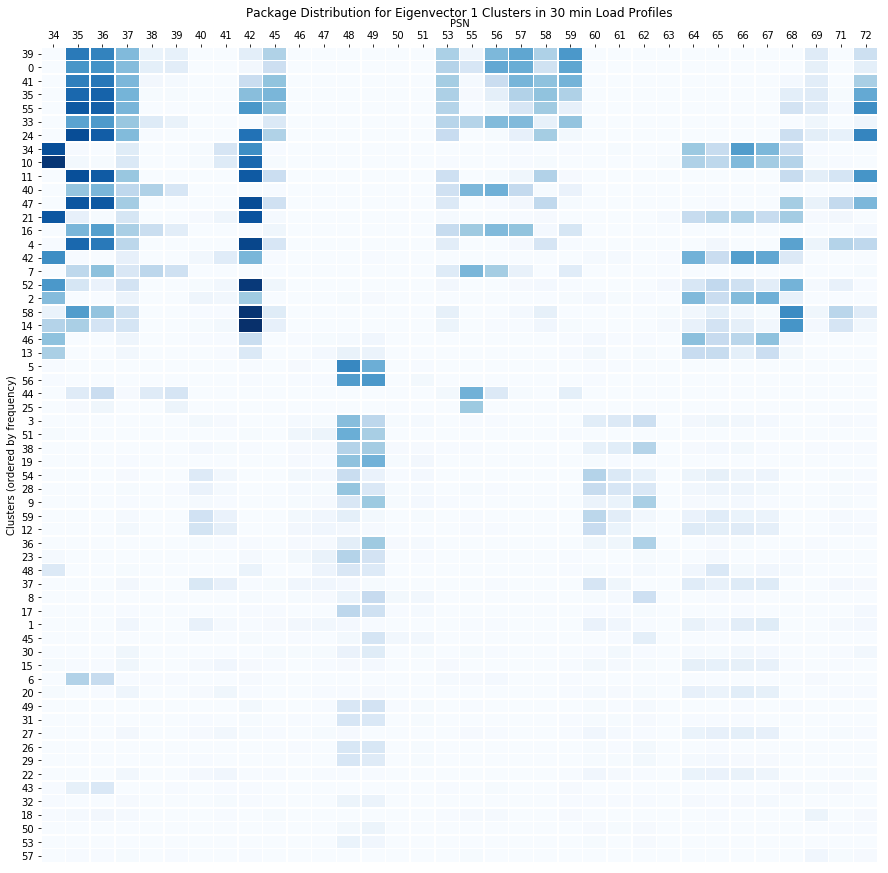

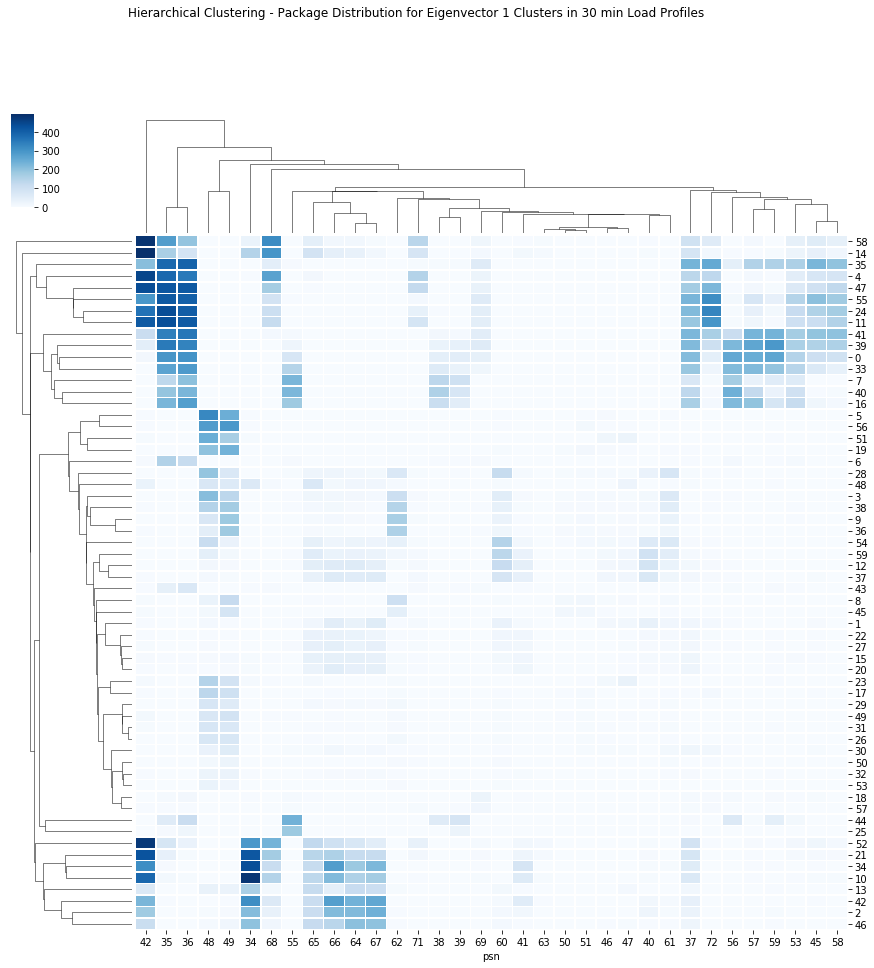

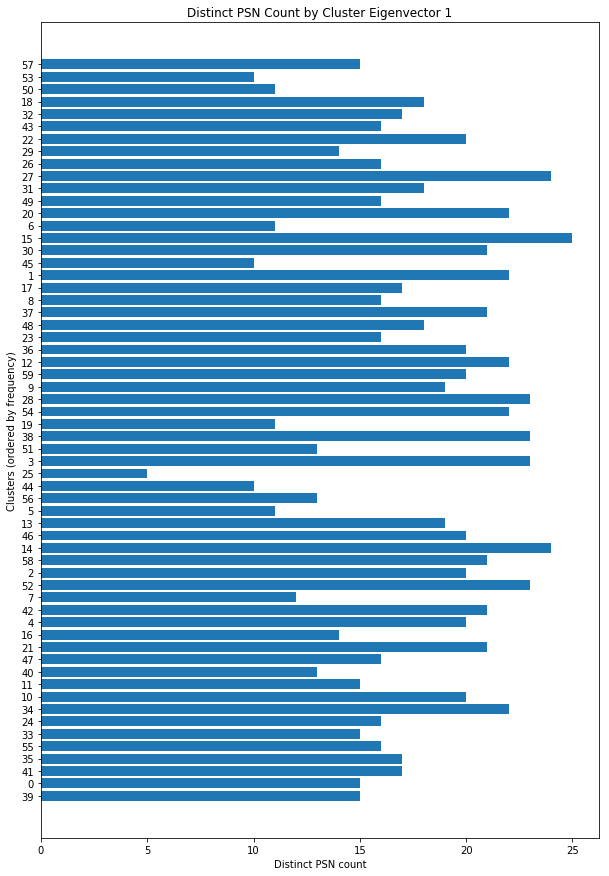

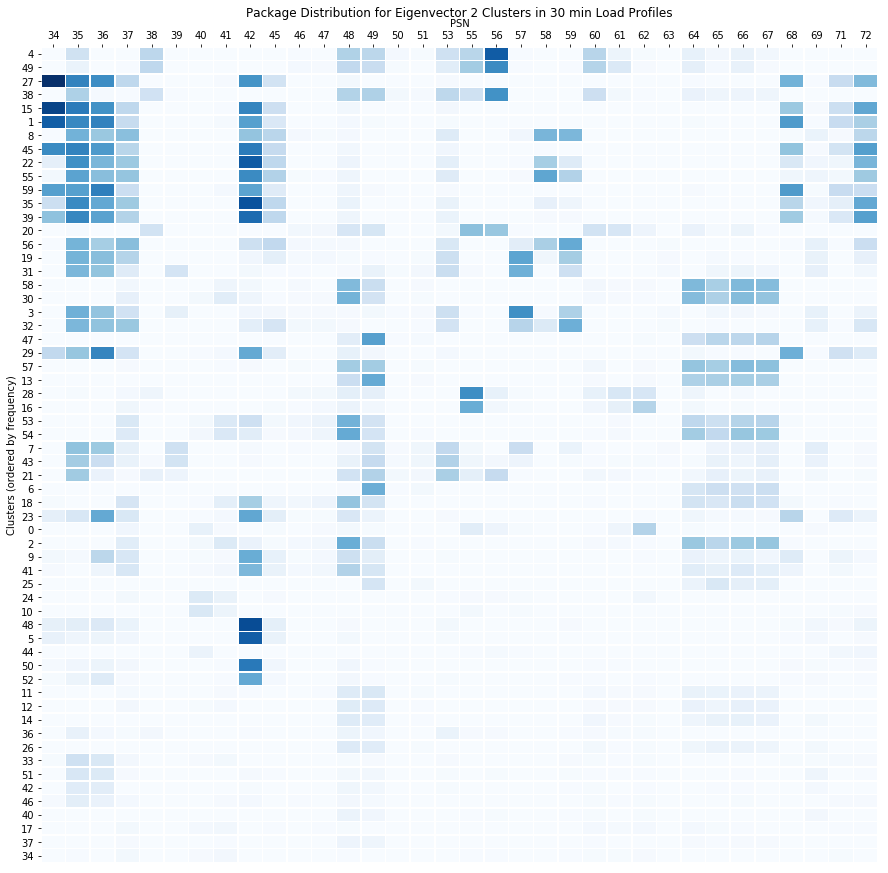

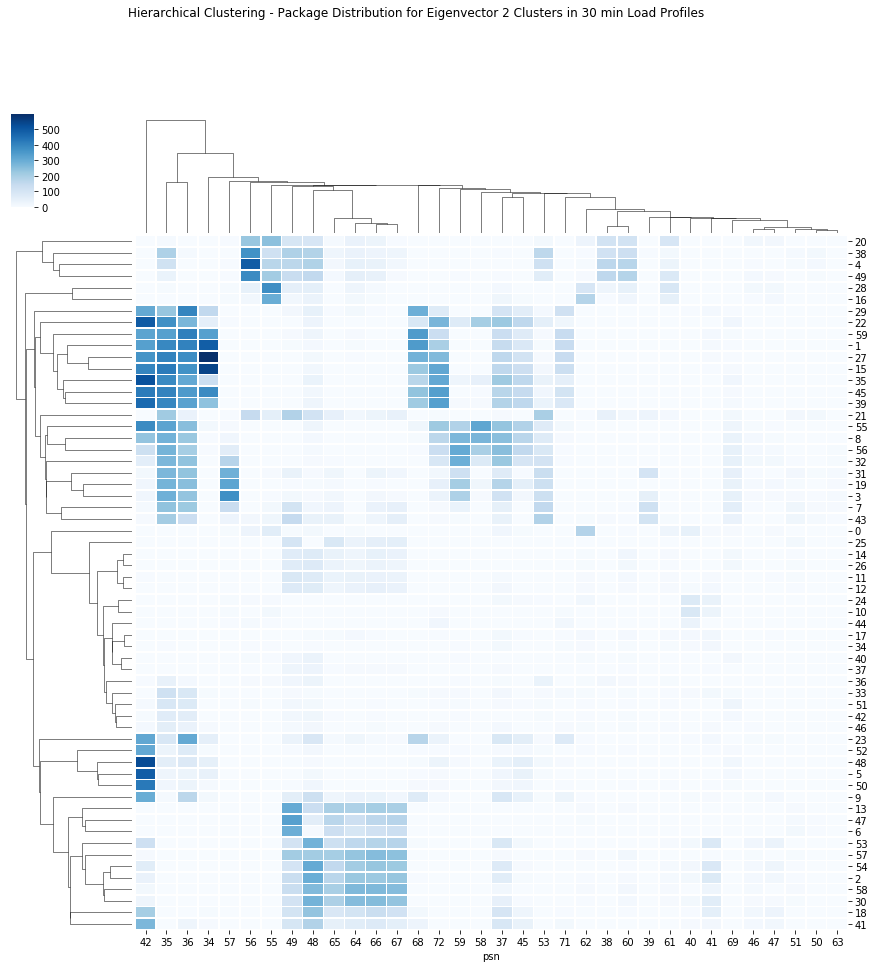

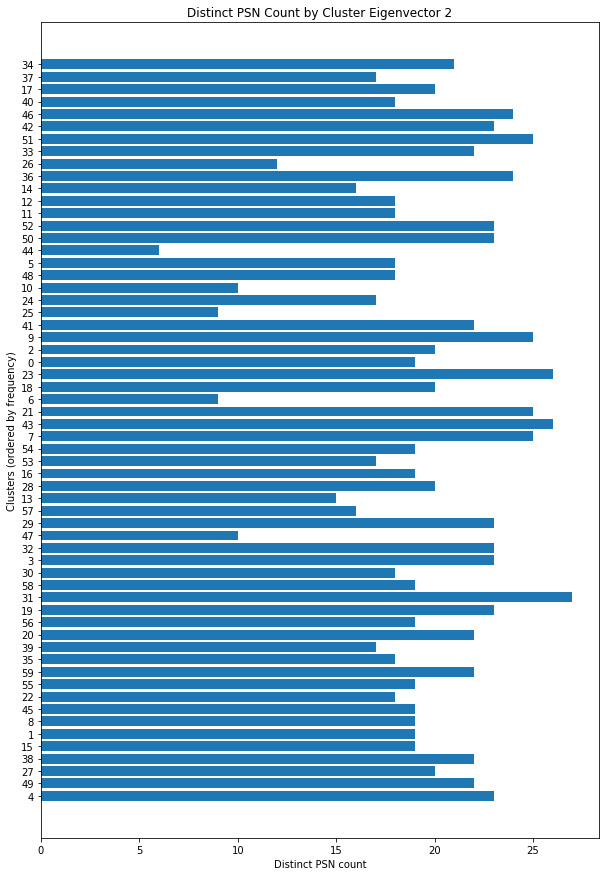

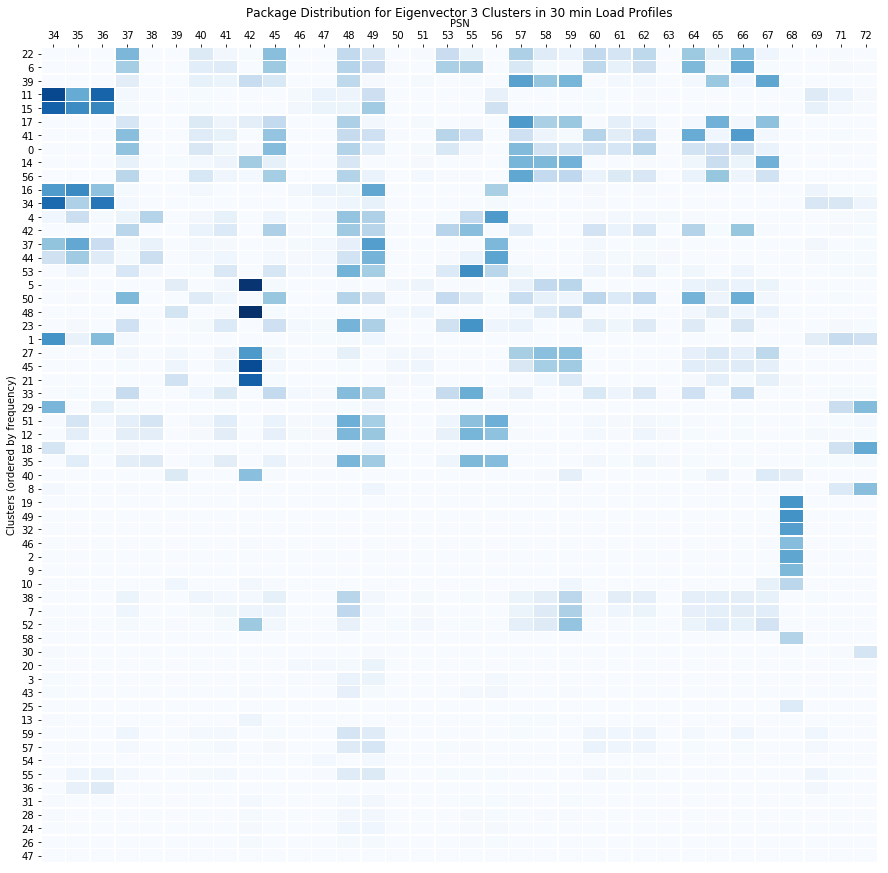

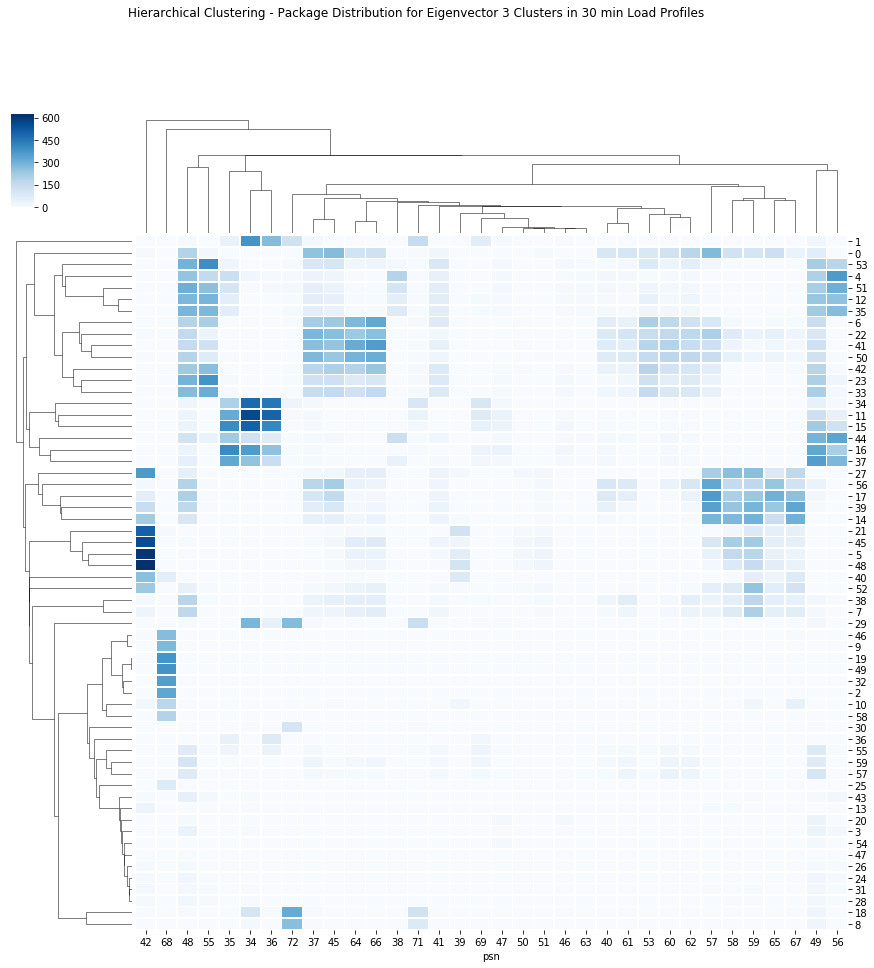

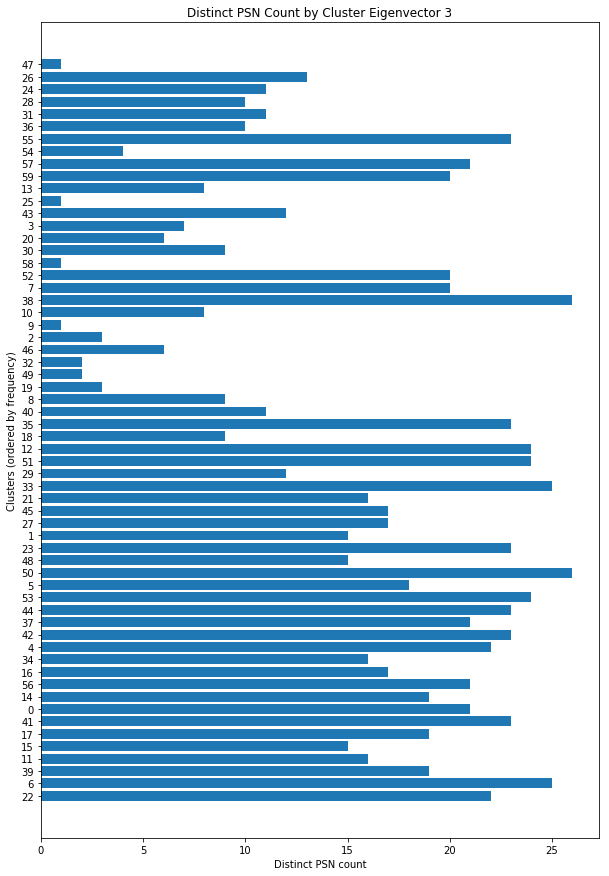

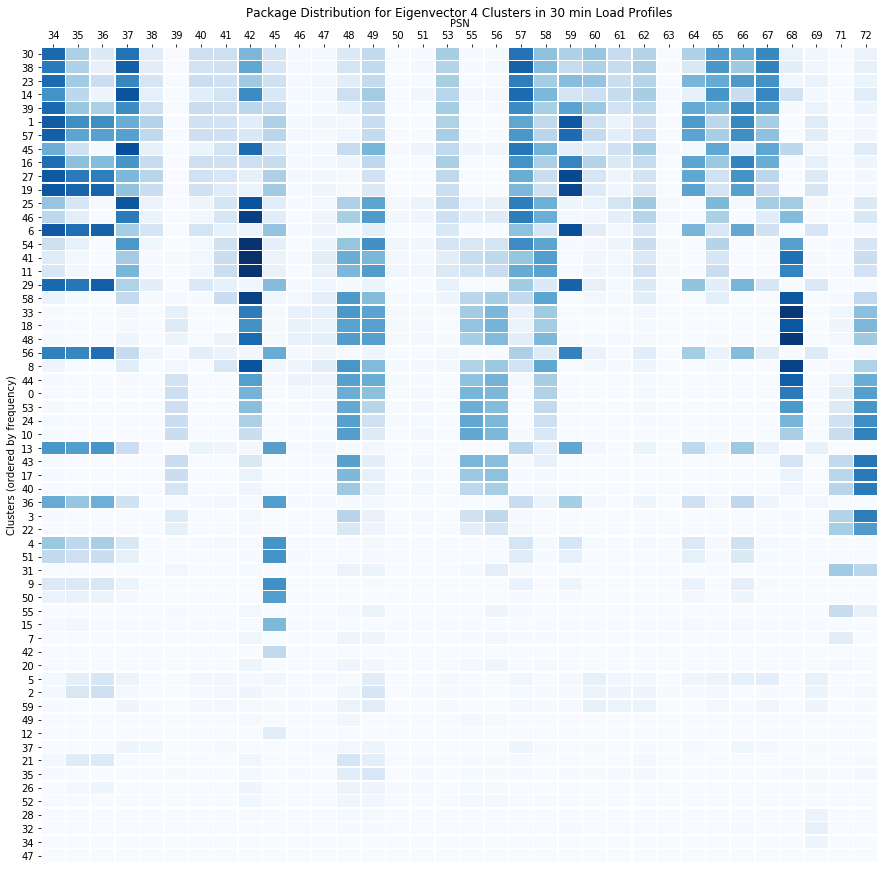

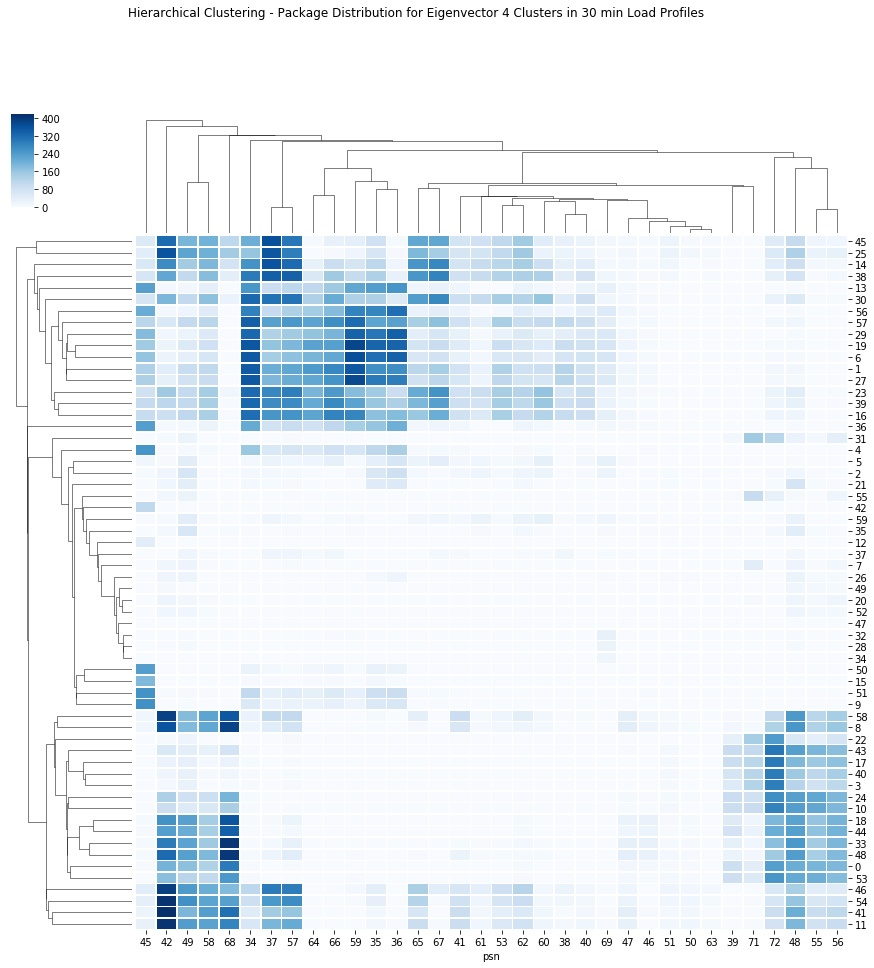

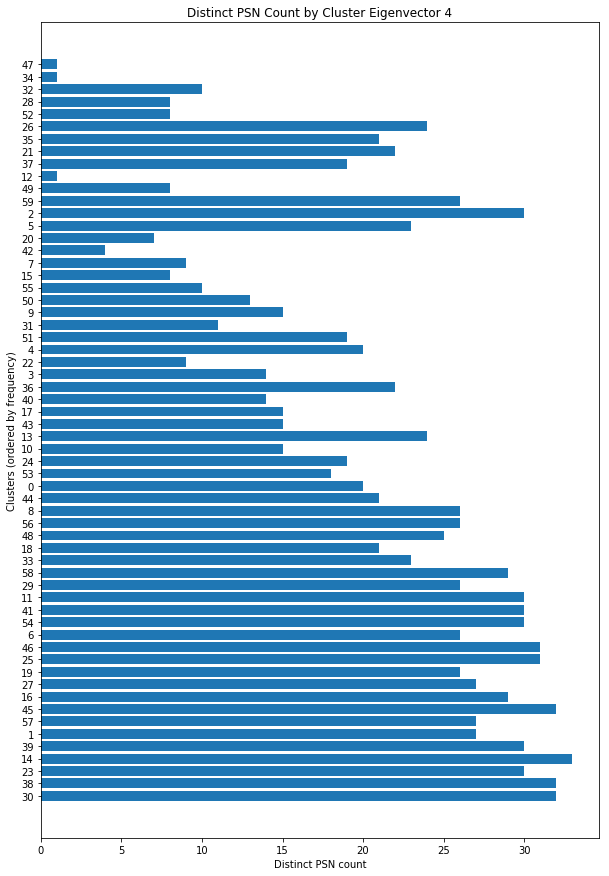

In [17]:
for i in [1,2,3,4]:
    eigDist = packageDistributions(i)
    eigDist.to_csv(folderOutput+'Package_Distribution_for_Eigenvector_{}_Clusters_in_30_min_Load_Profiles.csv'.format(i))
    Heatmap = plotHeatmap(eigDist, i)
    plt.savefig(folderOutput+'Package_Distribution_for_Eigenvector_{}_Clusters_in_30_min_Load_Profiles.png'.format(i))
    Clustermap = plotClustermap(eigDist, i)
    plt.savefig(folderOutput+'HierarchicalClustering_Package_Distribution_for_Eigenvector_{}_Clusters_in_30_min_Load_Profiles.png'.format(i))
    distinctPackageToCluster(eigDist, i)
    plt.savefig(folderOutput+'Distinct_PSN_Count_by_Cluster_Eigvector_{}.png'.format(i))

## Conclusions

TBD -> Probably will need to get some help from Chad.